## Dynamic Delta Hedging Framework


Dynamic delta hedging is a complex process influenced by stochastic factors such as noise (volatility) and drift (trend) in asset price movements. This framework aims to optimize delta hedging by targeting the Sharpe Ratio, balancing between P&L variance and option book returns.

#### Goal of Dynamic Delta hedging: This project explores how to implement delta hedging dynamically in different market conditions.


1. Volatility:
   
   a) High volatility: Prices swing widely, increasing the cost of frequent hedging.
 
   b)Low volatility: Prices are more stable, allowing frequent and precise hedging.

2. Drift:
   
   a) Represents the underlying trend of an asset’s price (upward or downward).
   b) High drift suggests a strong directional movement; low drift implies less trend.

3. Market Regimes:

   a) Combine volatility and drift to classify the market into different regimes:
   b) Low Volatility & Low Drift: Stable markets.
   c) High Volatility & High Drift: Turbulent markets.

The hedging strategy adapts based on the identified regime.

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

In [2]:
# Enable Yahoo Finance override for data fetching
yf.pdr_override()

# Step 1: Fetch Financial Data
start_date = '2020-01-01'
end_date = '2024-01-01'
ticker = 'QQQ'  # Example stock (S&P 500 ETF)

# Fetch data from Yahoo Finance
data = yf.download(ticker, start=start_date, end=end_date)

yfinance: pandas_datareader support is deprecated & semi-broken so will be removed in a future verison. Just use yfinance.


[*********************100%%**********************]  1 of 1 completed


# Step 2: Calculate Metrics

## Objective
The aim of this step is to calculate key metrics like **returns** and **volatility** which are essential for analyzing the stock's price behavior and assessing risk.

---

## Key Metrics Explained

### 1. Returns
**Returns** represent the percentage change in the stock's price over a given period. It gives insight into the performance of the stock.
\[
\text{Returns} = \frac{\text{Price at time } t - \text{Price at time } t-1}{\text{Price at time } t-1}
\]
- **Daily Returns**: Used to observe how the stock price changes day-to-day.
- In the code, this is calculated as the percentage change in the adjusted closing prices.

---

### 2. Volatility
**Volatility** measures the variability or risk associated with the stock's price movements. It is computed as the standard deviation of returns and represents the level of uncertainty or risk in the market.
\[
\text{Volatility} = \text{Standard Deviation of Returns} \times \sqrt{\text{Trading Days}}
\]
- **Rolling Window Volatility**:
  - A rolling window (e.g., 21 days for 1 month) is used to compute moving volatility.
  - Rolling volatility helps capture dynamic changes in market risk.

---

### 3. Intraday Volatility
**Intraday Volatility** quantifies the variability in a stock's price within a single day. It is calculated as the logarithmic difference between the highest and lowest prices of the day.
\[
\text{Intraday Volatility} = \log\left(\frac{\text{High Price}}{\text{Low Price}}\right)
\]
- A rolling window can also be applied to observe trends in intraday volatility over time.

---

## Summary
- **Returns** show the percentage change in stock prices over time.
- **Volatility** measures the risk level in the stock's price movements.
- **Intraday Volatility** captures price variability within a single day.

These metrics provide a foundation for analyzing market regimes and implementing the delta-hedging strategy.

In [3]:
# Step 2: Calculate Metrics
# Calculate daily returns
data['Returns'] = data['Adj Close'].pct_change()

# Calculate rolling volatilities
data['1M_Vol'] = data['Returns'].rolling(window=21).std() * np.sqrt(252)  # 1-month volatility
data['2D_Vol'] = data['Returns'].rolling(window=2).std() * np.sqrt(252)   # 2-day volatility
data['Intraday_Vol'] = np.log(data['High'] / data['Low']).rolling(window=21).std() * np.sqrt(252)  # Intraday volatility

# Step 3: Check for Missing Values Before Filtering
missing_values_before = data.isnull().sum()

# Step 4: Dynamically Ignore Rows with Missing Values in All Critical Metrics
filtered_data = data[data['Returns'].notna() & 
                     data['1M_Vol'].notna() & 
                     data['2D_Vol'].notna() & 
                     data['Intraday_Vol'].notna()]

# Step 5: Check for Missing Values After Filtering
missing_values_after = filtered_data.isnull().sum()

# Step 6: Display Results
print("Missing Values (Before Filtering):\n", missing_values_before)
print("\nMissing Values (After Filtering All Metrics):\n", missing_values_after)
print("\nFiltered Data Preview:\n", filtered_data.head())

Missing Values (Before Filtering):
 Open             0
High             0
Low              0
Close            0
Adj Close        0
Volume           0
Returns          1
1M_Vol          21
2D_Vol           2
Intraday_Vol    20
dtype: int64

Missing Values (After Filtering All Metrics):
 Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume          0
Returns         0
1M_Vol          0
2D_Vol          0
Intraday_Vol    0
dtype: int64

Filtered Data Preview:
                   Open        High         Low       Close   Adj Close  \
Date                                                                     
2020-02-03  220.139999  222.889999  219.990005  222.380005  216.018173   
2020-02-04  225.419998  227.860001  224.649994  227.470001  220.962524   
2020-02-05  230.210007  230.250000  226.850006  228.220001  221.691071   
2020-02-06  228.789993  230.250000  227.979996  230.190002  223.604736   
2020-02-07  229.160004  230.440002  228.539993  229

# Market Regime Classification

In [4]:
# Step 4: Dynamically Ignore Rows with Missing Values in All Critical Metrics
filtered_data = data[data['Returns'].notna() & 
                     data['1M_Vol'].notna() & 
                     data['2D_Vol'].notna() & 
                     data['Intraday_Vol'].notna()].copy()  # Use .copy() to avoid SettingWithCopyWarning

# Step 5: Classify Market Regimes
# Define thresholds
vol_threshold = 1.5  # Threshold for volatility regime
trend_threshold = 1.2  # Threshold for trend regime

# Volatility Regime Classification
filtered_data['Vol_Regime'] = np.where(
    filtered_data['2D_Vol'] > filtered_data['1M_Vol'] * vol_threshold,
    'High Volatility',
    'Low Volatility'
)

# Calculate Variance Ratio
filtered_data['Variance_Ratio'] = filtered_data['Intraday_Vol'] / filtered_data['1M_Vol']

# Trend Regime Classification
filtered_data['Trend_Regime'] = np.where(
    filtered_data['Variance_Ratio'] < trend_threshold,
    'High Trend',
    'Low Trend'
)

# Check if warnings are gone and data is clean
print("\nFiltered Data with Regime Classification:\n", filtered_data[['Vol_Regime', 'Trend_Regime']].head())




Filtered Data with Regime Classification:
                  Vol_Regime Trend_Regime
Date                                    
2020-02-03  High Volatility   High Trend
2020-02-04   Low Volatility   High Trend
2020-02-05   Low Volatility   High Trend
2020-02-06   Low Volatility   High Trend
2020-02-07   Low Volatility   High Trend


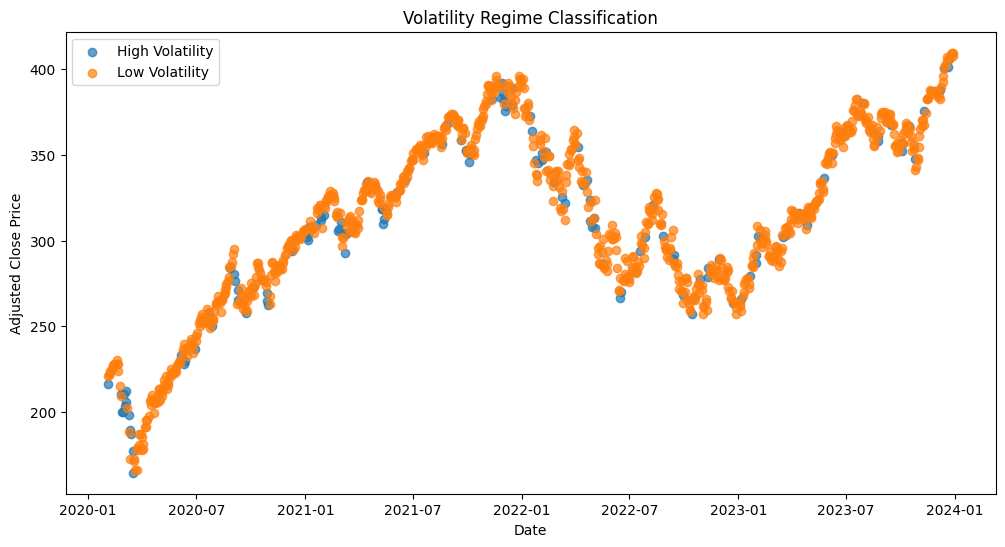

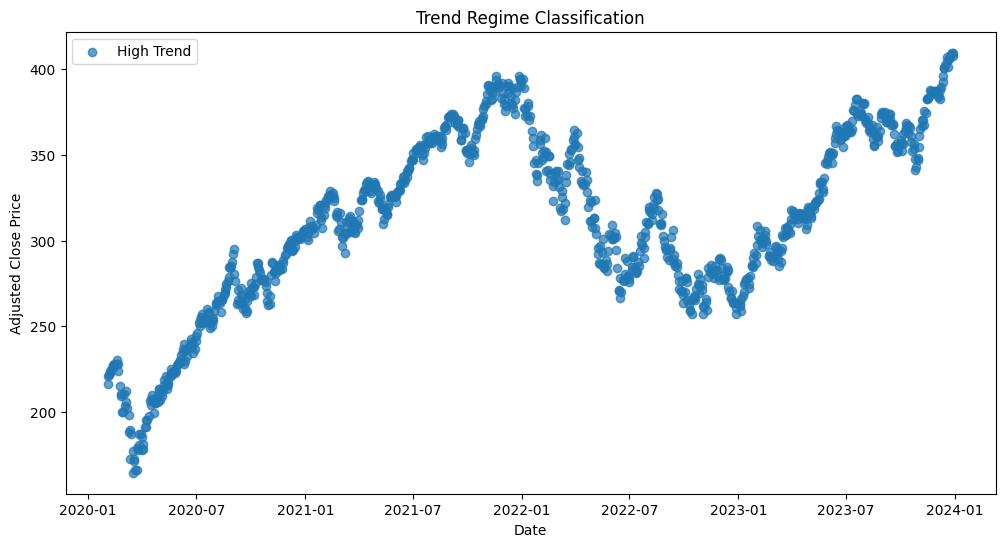

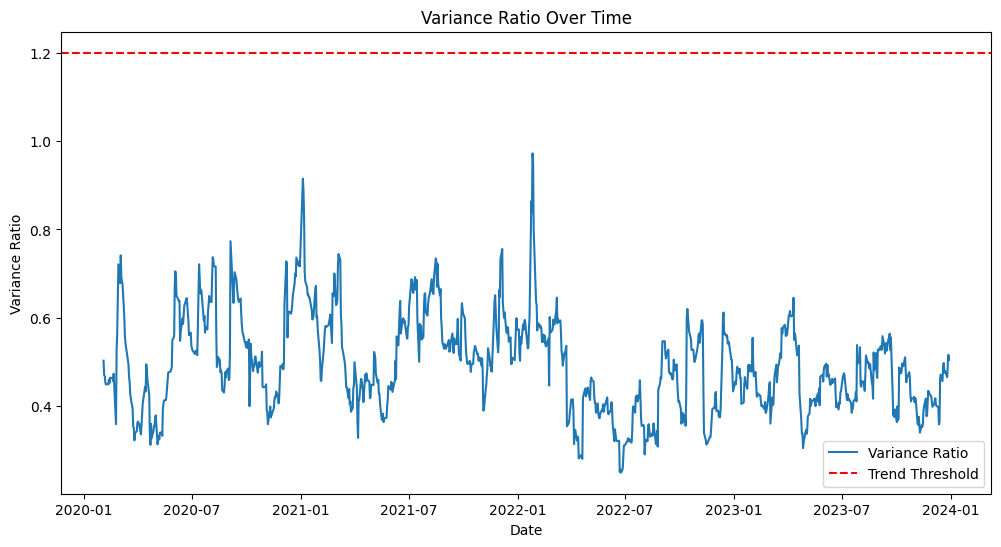

In [5]:
# Step 1: Volatility Regime Visualization
plt.figure(figsize=(12, 6))
for regime, group_data in filtered_data.groupby('Vol_Regime'):
    plt.scatter(group_data.index, group_data['Adj Close'], label=regime, alpha=0.7)
plt.title('Volatility Regime Classification')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

# Step 2: Trend Regime Visualization
plt.figure(figsize=(12, 6))
for regime, group_data in filtered_data.groupby('Trend_Regime'):
    plt.scatter(group_data.index, group_data['Adj Close'], label=regime, alpha=0.7)
plt.title('Trend Regime Classification')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

# Step 3: Variance Ratio Visualization
plt.figure(figsize=(12, 6))
plt.plot(filtered_data['Variance_Ratio'], label='Variance Ratio')
plt.axhline(trend_threshold, color='r', linestyle='--', label='Trend Threshold')
plt.title('Variance Ratio Over Time')
plt.xlabel('Date')
plt.ylabel('Variance Ratio')
plt.legend()
plt.show()



# Steps for Delta Hedging

In [6]:
# Initialize P&L tracking variables
filtered_data['PnL'] = 0.0
filtered_data['Cumulative_PnL'] = 0.0
filtered_data['Hedge_Action'] = False

# Initialize parameters
last_hedge_price = filtered_data['Adj Close'].iloc[0]
accumulated_delta = 0
threshold_delta = 0.05  # Example delta threshold for high volatility

# Loop through data to apply hedging strategy
for i in range(1, len(filtered_data)):
    current_price = filtered_data['Adj Close'].iloc[i]
    previous_price = filtered_data['Adj Close'].iloc[i - 1]
    current_vol_regime = filtered_data['Vol_Regime'].iloc[i]
    current_trend_regime = filtered_data['Trend_Regime'].iloc[i]

    # Determine hedging strategy
    if current_vol_regime == 'Low Volatility' and current_trend_regime == 'Low Trend':
        decision = 'Time-Based Hedging'
        hedge_price = current_price  # Hedge daily
    elif current_vol_regime == 'Low Volatility' and current_trend_regime == 'High Trend':
        decision = 'Percent Change-Based Hedging'
        if abs(current_price - last_hedge_price) / last_hedge_price > 0.01:  # 1% price change
            hedge_price = current_price
        else:
            hedge_price = None
    elif current_vol_regime == 'High Volatility' and current_trend_regime == 'Low Trend':
        decision = 'Accumulated Delta-Based Hedging'
        accumulated_delta += np.random.randn() * 0.01  # Random delta adjustment
        if abs(accumulated_delta) > threshold_delta:
            hedge_price = current_price
            accumulated_delta = 0  # Reset delta
        else:
            hedge_price = None
    else:
        decision = 'Custom Hedging for High Volatility / High Trend'
        hedge_price = None

    # Calculate P&L if hedging action is taken
    if hedge_price is not None:
        filtered_data.at[filtered_data.index[i], 'Hedge_Action'] = True
        pnl = (hedge_price - previous_price) * 1  # Assuming 1 unit hedged
        filtered_data.at[filtered_data.index[i], 'PnL'] = pnl
        last_hedge_price = hedge_price
    else:
        filtered_data.at[filtered_data.index[i], 'PnL'] = 0.0

    # Update cumulative P&L
    filtered_data.at[filtered_data.index[i], 'Cumulative_PnL'] = (
        filtered_data['Cumulative_PnL'].iloc[i - 1] + filtered_data['PnL'].iloc[i]
    )

# Display results
print("\nHedging Strategy Results:\n", filtered_data[['Adj Close', 'Vol_Regime', 'Trend_Regime', 'Hedge_Action', 'PnL', 'Cumulative_PnL']].head())

# Save results
filtered_data.to_csv(r"C:\Users\vagel\Desktop\Python Projects\Dynamic Delta Hedging\dynamic_delta_hedging_results.csv", index=True)




Hedging Strategy Results:
              Adj Close       Vol_Regime Trend_Regime  Hedge_Action       PnL  \
Date                                                                           
2020-02-03  216.018173  High Volatility   High Trend         False  0.000000   
2020-02-04  220.962524   Low Volatility   High Trend          True  4.944351   
2020-02-05  221.691071   Low Volatility   High Trend         False  0.000000   
2020-02-06  223.604736   Low Volatility   High Trend          True  1.913666   
2020-02-07  222.643051   Low Volatility   High Trend         False  0.000000   

            Cumulative_PnL  
Date                        
2020-02-03        0.000000  
2020-02-04        4.944351  
2020-02-05        4.944351  
2020-02-06        6.858017  
2020-02-07        6.858017  


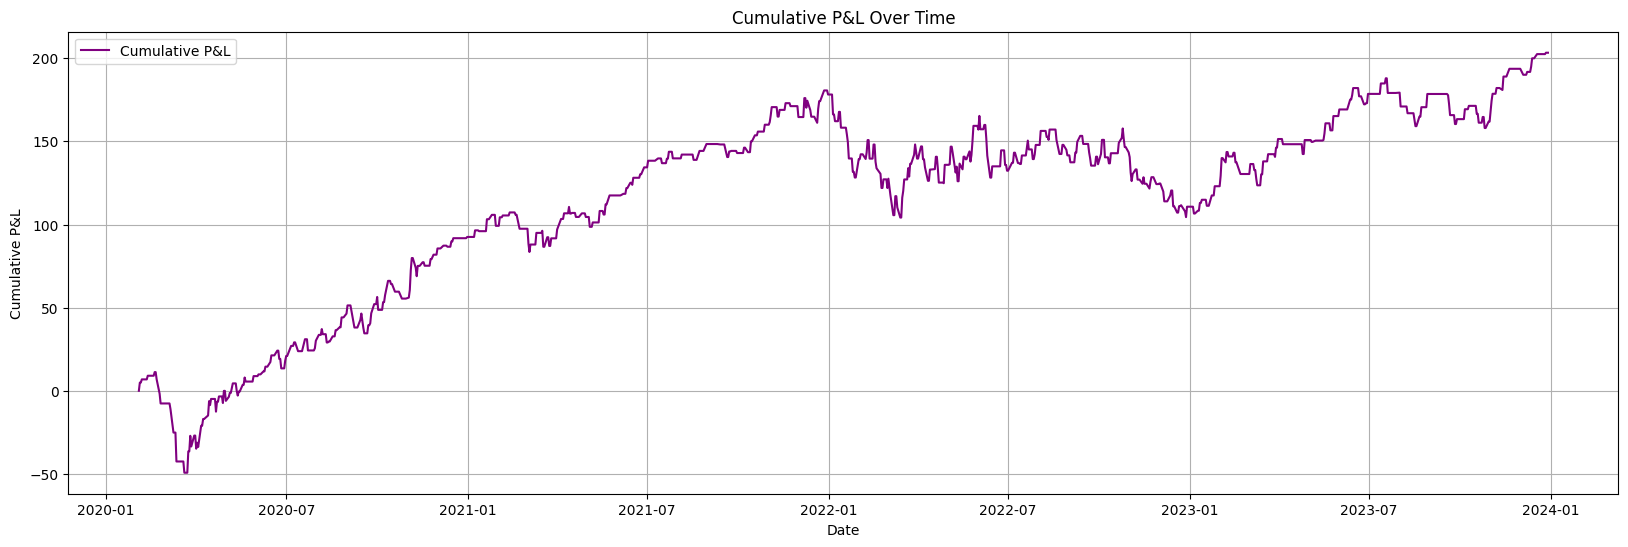

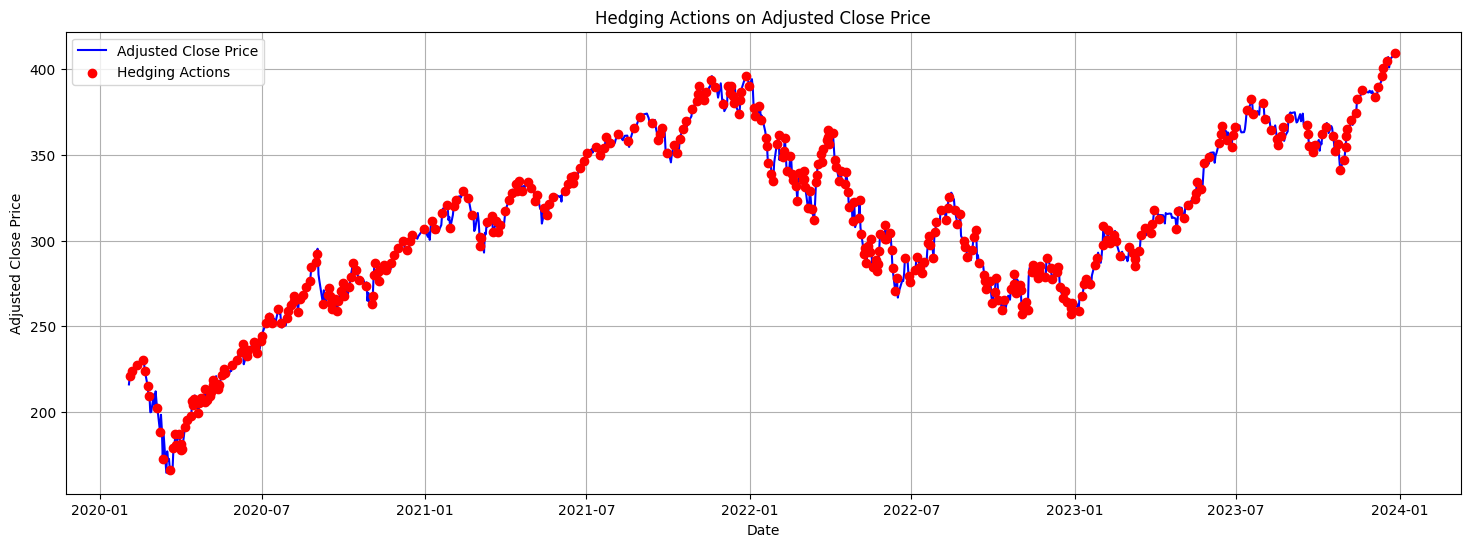

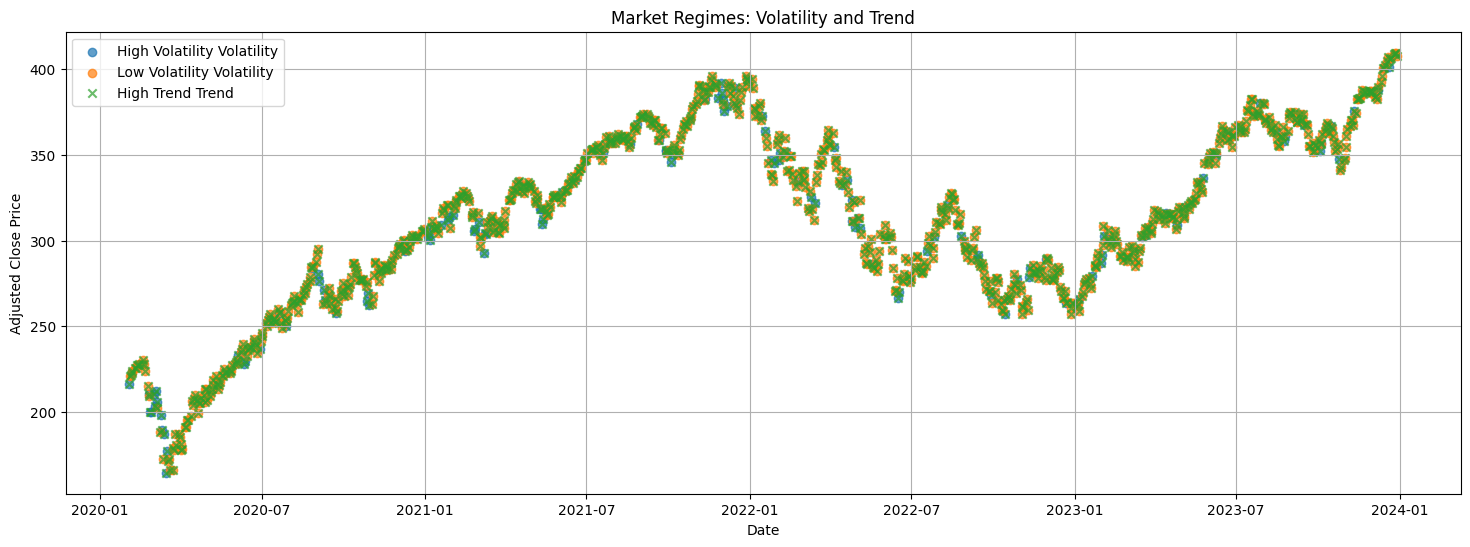

In [7]:
# Ensure the required columns exist
required_columns = ['Adj Close', 'Cumulative_PnL', 'Hedge_Action', 'Vol_Regime', 'Trend_Regime']
if not all(col in filtered_data.columns for col in required_columns):
    print("Error: Some required columns are missing in the dataset.")
else:
    # Step 1: Plot Cumulative P&L Over Time
    plt.figure(figsize=(20, 6))
    plt.plot(filtered_data['Cumulative_PnL'], label='Cumulative P&L', color='purple')
    plt.title('Cumulative P&L Over Time')
    plt.xlabel('Date')
    plt.ylabel('Cumulative P&L')
    plt.legend()
    plt.grid()
    plt.show()

    # Step 2: Plot Hedging Actions on Price Chart
    plt.figure(figsize=(18, 6))
    plt.plot(filtered_data['Adj Close'], label='Adjusted Close Price', color='blue')
    hedge_dates = filtered_data[filtered_data['Hedge_Action']].index
    hedge_prices = filtered_data[filtered_data['Hedge_Action']]['Adj Close']
    plt.scatter(hedge_dates, hedge_prices, color='red', label='Hedging Actions', zorder=5)
    plt.title('Hedging Actions on Adjusted Close Price')
    plt.xlabel('Date')
    plt.ylabel('Adjusted Close Price')
    plt.legend()
    plt.grid()
    plt.show()

    # Step 3: Plot Volatility and Trend Regimes
    plt.figure(figsize=(18, 6))
    for regime, group_data in filtered_data.groupby('Vol_Regime'):
        plt.scatter(group_data.index, group_data['Adj Close'], label=f'{regime} Volatility', alpha=0.7)
    for regime, group_data in filtered_data.groupby('Trend_Regime'):
        plt.scatter(group_data.index, group_data['Adj Close'], label=f'{regime} Trend', alpha=0.7, marker='x')
    plt.title('Market Regimes: Volatility and Trend')
    plt.xlabel('Date')
    plt.ylabel('Adjusted Close Price')
    plt.legend()
    plt.grid()
    plt.show()